<a href="https://colab.research.google.com/github/jngadiub/ML_course_Pavia_23_WIP/blob/main/PartT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jet Tagging with Set Transformer

In this notebook we will see an implementation of the Transformer architecture for sets applied to the jet tagging task. For *sets* it is meant here a point cloud, i.e. a set of nodes without edges. We will instead use Multi-Head Attention to learn which nodes (or particles) have strong pair-wise interaction.

The architecture was introduced by [J. Lee at al. (ICML 2019)](https://arxiv.org/abs/1810.00825) --  specifically designed to model interactions among elements in the input set without pre-defined edges. The model consists of an encoder and a decoder, both of which rely on attention mechanisms, as in the original Transformer implementation [by Vaswani](https://arxiv.org/abs/1706.03762). The main difference is that positional encoding is removed plus some other low level adaptions.

We will use tensorflow for this implementation.

Before you start, choose GPU as a hardware accelerator for this notebook. To do this first go to Edit -> Notebook Settings -> Choose GPU as a hardware accelerator.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
import h5py
import numpy as np
import matplotlib.pyplot  as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import roc_curve, auc
from networks import TransformerNet,RegNet,ClassNet,OutNet

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-08-11 19:00:21.018793: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Num GPUs Available:  1


2023-08-11 19:00:23.053881: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-08-11 19:00:23.054482: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-08-11 19:00:23.170378: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:98:00.0 name: NVIDIA A30 computeCapability: 8.0
coreClock: 1.44GHz coreCount: 56 deviceMemorySize: 23.50GiB deviceMemoryBandwidth: 869.04GiB/s
2023-08-11 19:00:23.170397: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-08-11 19:00:23.173043: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-08-11 19:00:23.173086: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-08-11 

In [2]:
# let's open the file
data_dir = 'Data-MLtutorial/JetDataset/'
fileIN = data_dir+'jetImage_7_100p_30000_40000.h5'
f = h5py.File(fileIN,"r")
# and see what it contains
print(list(f.keys()))

['jetConstituentList', 'jetFeatureNames', 'jetImage', 'jetImageECAL', 'jetImageHCAL', 'jets', 'particleFeatureNames']


In [3]:
target_onehot = np.array([])
jetList = np.array([])
jetImages = np.array([])
target_reg = np.array([])
features_names = dict()
datafiles = ['jetImage_7_100p_0_10000.h5',
             'jetImage_7_100p_10000_20000.h5',
             'jetImage_7_100p_30000_40000.h5',
             'jetImage_7_100p_40000_50000.h5',
             'jetImage_7_100p_50000_60000.h5',
             'jetImage_7_100p_60000_70000.h5',
             'jetImage_7_100p_70000_80000.h5',
             'jetImage_7_100p_80000_90000.h5'
            ]
for i_f,fileIN in enumerate(datafiles):
    print("Appending %s" %fileIN)
    f = h5py.File(data_dir + fileIN)
    jetList_file = np.array(f.get("jetConstituentList"))
    target_file = np.array(f.get('jets')[0:,-6:-1])
    mass = np.array(f.get("jets")[0:,3])    
    jetImages_file = np.array(f.get('jetImage'))
    jetList = np.concatenate([jetList, jetList_file], axis=0) if jetList.size else jetList_file
    target_onehot = np.concatenate([target_onehot, target_file], axis=0) if target_onehot.size else target_file
    jetImages = np.concatenate([jetImages, jetImages_file], axis=0) if jetImages.size else jetImages_file
    target_reg = np.concatenate([target_reg,mass],axis=0)
    del jetList_file, target_file, jetImages_file, mass
    #save particles/nodes features names and their indecies in a dictionary
    if i_f==0:
      for feat_idx,feat_name in enumerate(list(f['particleFeatureNames'])[:-1]):
        features_names[feat_name.decode("utf-8").replace('j1_','')] = feat_idx
    f.close()

/tmp/ipykernel_144462/3009411415.py:17: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(data_dir + fileIN)


Appending jetImage_7_100p_0_10000.h5
Appending jetImage_7_100p_10000_20000.h5
Appending jetImage_7_100p_30000_40000.h5
Appending jetImage_7_100p_40000_50000.h5
Appending jetImage_7_100p_50000_60000.h5
Appending jetImage_7_100p_60000_70000.h5
Appending jetImage_7_100p_70000_80000.h5
Appending jetImage_7_100p_80000_90000.h5


In [4]:
target = np.argmax(target_onehot, axis=1)
num_classes = len(np.unique(target))
label_names= ["gluon", "quark", "W", "Z", "top"]

In [5]:
print('Jets shape : ',jetList.shape)
print('Target/Labels shape : ',target.shape)
print('Particles/Nodes features : ',list(features_names.keys()))

Jets shape :  (80000, 100, 16)
Target/Labels shape :  (80000,)
Particles/Nodes features :  ['px', 'py', 'pz', 'e', 'erel', 'pt', 'ptrel', 'eta', 'etarel', 'etarot', 'phi', 'phirel', 'phirot', 'deltaR', 'costheta', 'costhetarel']


In [6]:
labelCat = ["gluon", "quark", "W", "Z", "top"]
def plot_features(features):
    for i,f in enumerate(features.keys()):
        for l in range(num_classes):
            idxs  = np.where([target==l])
            plt.hist(jetList[idxs,:,i].flatten(),50, density=True, histtype='step', fill=False, linewidth=1.5,label=labelCat[l])
        plt.yscale('log')    
        plt.legend(fontsize=12, frameon=False)
        plt.xlabel(f)
        plt.ylabel('Prob. Density (a.u.)', fontsize=15)
        plt.show()
#plot_features(features_names)

In [7]:
features_to_consider = 'etarel,phirel,pt,e,ptrel,erel,deltaR'.split(',')
features_idx = [features_names[name] for name in features_to_consider]
jetList = jetList[:,:,features_idx]
max_mass = np.max(target_reg)
target_reg /= max_mass
print(jetList.shape)

(80000, 100, 7)


In [8]:
batch_size=64
learning_rate=0.001
epochs=20

In [9]:
hidden_dimensions = 64

t_net = TransformerNet(num_heads=8, hidden_units=hidden_dimensions)
r_net = RegNet(hidden_dimensions)
c_net = ClassNet(hidden_dimensions)
o_net = OutNet(hidden_dimensions, [r_net])

inputs = keras.Input(shape=(100,7), name='input')
output = layers.TimeDistributed(layers.Dense(hidden_dimensions))(inputs)
output = t_net(output)
output = layers.Lambda(lambda y: tf.reduce_sum(y, axis=1))(output)
output = [r_net(output), c_net(output)]

model = keras.models.Model(inputs=inputs, outputs=output)
model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-08-11 19:00:51.978523: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 19:00:51.978614: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-08-11 19:00:51.981486: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:98:00.0 name: NVIDIA A30 computeCapability: 8.0
coreClock: 1.44GHz coreCount: 56 deviceMemorySize: 23.50GiB deviceMemoryBandwidth: 869.04GiB/s
2023-08-11 19:00:51.981511: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-08-11 19:00:51.981547: I tensorflow/stream_executor/platform/default/

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 100, 7)]     0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 100, 64)      512         input[0][0]                      
__________________________________________________________________________________________________
mab (MAB)                       (None, 100, 64)      33472       time_distributed[0][0]           
__________________________________________________________________________________________________
mab_1 (MAB)                     (None, 100, 64)      33472       mab[0][0]                        
______________________________________________________________________________________________

In [10]:
model.compile(
    loss=["mse", keras.losses.SparseCategoricalCrossentropy(from_logits=True)],
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=keras.metrics.SparseCategoricalAccuracy(),
    loss_weights=[0.5,0.5])

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train_class, y_val_class, y_train_reg, y_val_reg, y_train_onehot, y_val_onehot = train_test_split(jetList, target,target_reg, target_onehot, test_size=0.1, shuffle=True)
print(X_train.shape, X_val.shape, y_train_class.shape, y_val_class.shape, y_train_reg.shape, y_val_reg.shape)
del jetList, target, target_onehot

(72000, 100, 7) (8000, 100, 7) (72000,) (8000,) (72000,) (8000,)


In [12]:
history = model.fit(x=X_train, 
                    y=[y_train_reg,y_train_class], 
                    validation_data=(X_val,[y_val_reg,y_val_class]), 
                    batch_size=batch_size, 
                    epochs=epochs,
                    verbose=1,
                    callbacks = [ EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                                  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                                  TerminateOnNaN()]
                   )

2023-08-11 19:00:54.069611: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-08-11 19:00:54.081515: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2800000000 Hz


Epoch 1/20


2023-08-11 19:00:55.434293: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


1125/1125 [==============================] - 14s 11ms/step - loss: 0.6474 - Reg_loss: 0.0134 - Class_loss: 1.2814 - Reg_sparse_categorical_accuracy: 0.0000e+00 - Class_sparse_categorical_accuracy: 0.4350 - val_loss: 1.4292 - val_Reg_loss: 0.0308 - val_Class_loss: 2.8277 - val_Reg_sparse_categorical_accuracy: 0.0000e+00 - val_Class_sparse_categorical_accuracy: 0.3129
Epoch 2/20
1125/1125 [==============================] - 12s 11ms/step - loss: 0.4768 - Reg_loss: 0.0017 - Class_loss: 0.9519 - Reg_sparse_categorical_accuracy: 0.0000e+00 - Class_sparse_categorical_accuracy: 0.6163 - val_loss: 0.7610 - val_Reg_loss: 0.0118 - val_Class_loss: 1.5102 - val_Reg_sparse_categorical_accuracy: 0.0000e+00 - val_Class_sparse_categorical_accuracy: 0.4756
Epoch 3/20
1125/1125 [==============================] - 12s 11ms/step - loss: 0.4414 - Reg_loss: 0.0010 - Class_loss: 0.8818 - Reg_sparse_categorical_accuracy: 0.0000e+00 - Class_sparse_categorical_accuracy: 0.6578 - val_loss: 1.3104 - val_Reg_loss: 0

We can now plot the validation and training loss evolution over the epochs:

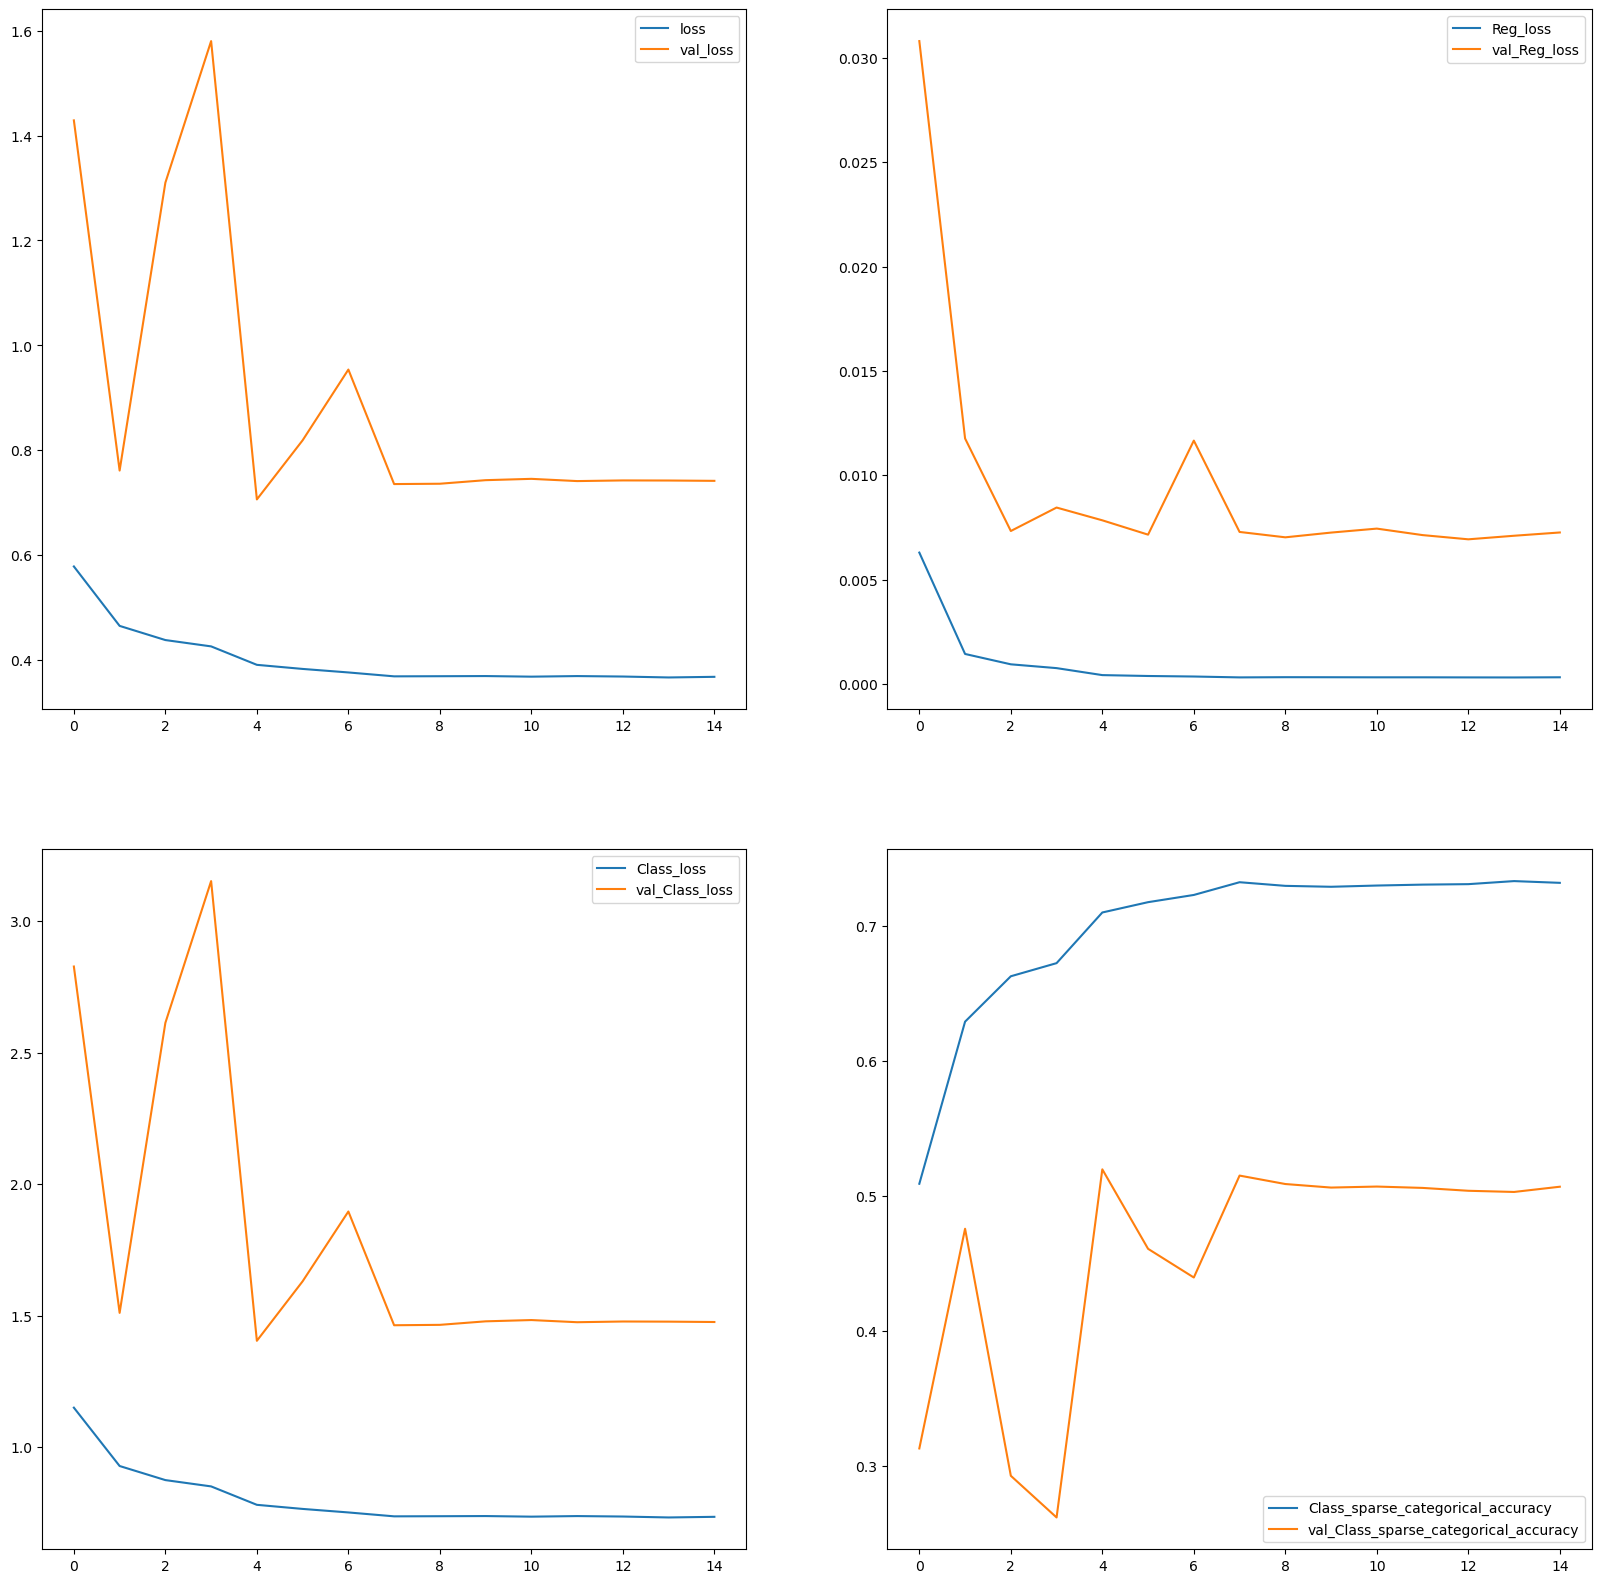

In [13]:
keys = ["loss","Reg_loss","Class_loss","Class_sparse_categorical_accuracy"]
fig,axes = plt.subplots(2,2, figsize=(20,20))
for ax, key in zip(axes.flat, keys):
    ax.plot([i for i in range(len(history.history[key]))],history.history[key],label=key)
    ax.plot([i for i in range(len(history.history[key]))],history.history["val_"+key],label="val_"+key)
    ax.legend()

fig.show()

Now we finally evaluate the performance by plotting the ROC curves for the different classes:

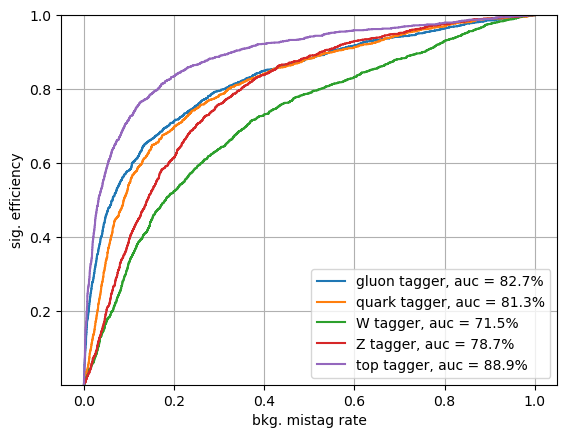

In [16]:
%matplotlib inline
predict_val = tf.nn.softmax(model.predict(X_val)[1]) # index 0 is the regression predictio
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(label_names):

        df[label] = y_val_onehot[:,i]
        df[label + '_pred'] = predict_val[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(fpr[label],tpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
#plt.semilogy()
plt.ylabel("sig. efficiency")
plt.xlabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

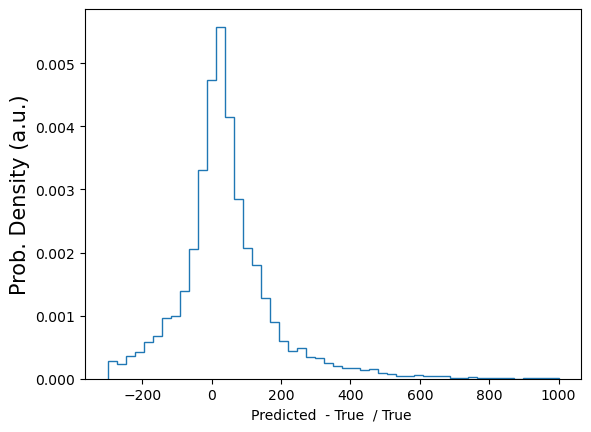

In [22]:
predict_reg = model.predict(X_val)[0].flatten()
plt.hist(((predict_reg-y_val_reg)/y_val_reg)*max_mass,50,(-300,1000),density=True,histtype="step")
plt.xlabel("Predicted  - True  / True ")
plt.ylabel('Prob. Density (a.u.)', fontsize=15)
plt.show()